# NeRF(ECCV 2020) sampling

首先回顾一下最开始ECCV2020那篇NeRF的采样方式

>鼠鼠因为最近又要搞NeRF所以把之前暑假里看论文记的笔记翻出来看了看，结果发现有些地方写的实在是让鼠鼠怀疑当时的精神状态，所以参照源代码重新过了一遍论文里体渲染的流程，顺便写这个notebook方便可视化（jupyter，好耶！）

假设下面是一条ray上的density分布 （图c）

![s](imgs/pipeline.jpg)

PS: 这里的给出函数的density分布是已经处理过归一到[0,1]上的，所以下面我们使用near=0,far=1，真实情况下的density分布也随near和far而变换

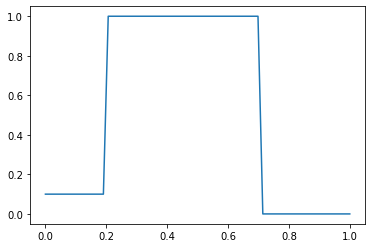

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import torch
N_samples = 256

def sigma_distr(x):
    mu1, sigma1 = 0.2, 0.07
    mu2, sigma2 = 0.5, 0.1
    mu3, sigma3 = 0.8, 0.1

    # 三个高斯分布的概率密度函数
    y1 = 0.2 * (np.exp(-((x - mu1)**2) / (2 * sigma1**2)) / (sigma1 * np.sqrt(2*np.pi)))/(1/ (sigma1 * np.sqrt(2*np.pi)))
    y2 = 0.1 * (np.exp(-((x - mu2)**2) / (2 * sigma2**2)) / (sigma2 * np.sqrt(2*np.pi)))/(1/ (sigma2 * np.sqrt(2*np.pi)))
    y3 = 1.0 * (np.exp(-((x - mu3)**2) / (2 * sigma3**2)) / (sigma3 * np.sqrt(2*np.pi)))/(1/ (sigma3 * np.sqrt(2*np.pi)))

    return y1 + y2 + y3

def sigma_distr(x):
    if x < 0.2:
        return 0.1
    if x < 0.7:
        return 1.
    else:
        return 0
    
x = np.linspace(0, 1, 64)# 对射线进行均匀采样

plt.plot(x, [sigma_distr(i) for i in x])
plt.show()
#print(x)

## NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis
首先我们来回顾一下原始论文中的基本采样和渲染操作：
现在我们把采样点从[0,1]线性映射到[near,far]上，并且为它增加随机抖动来避免生成一些artifacts，提高生成质量；
这里我们增加的随机抖动不能直接在每个采样点上加随机数，因为我们必须保证增加随机抖动之后，采样点的顺序依旧是从小到大的，下面是具体的实现trick：
1. 得到N_samples-1个区间，进而得到N_samples个区间的中点
2. 有N_samles-1个中点的数组，在开头concat上near(在末尾concat上far)，得到N_samples个元素的lower数组(upper数组)

这样操作以后，我们就相当于把N_samples个采样点对应到N_samples个区间上（第i个采样点的下界是lower[i]上界是upper[i]），这样在区间内随机采样，就可以保证采样点的顺序依旧是从小到大的


In [145]:
near = 0
far = 1
z = near * (1 - x) + far * x

mids = .5 * (z[1:] + z[:-1])
#upper = torch.cat([mids, z[-1:]], -1)
upper = np.concatenate((mids, z[-1:]), -1)
lower = np.concatenate((z[:1],mids), -1)

t_rand = np.random.uniform(0, 0.5, z.shape)


#print("evenly-distributed z:",z)
#print("upper:",upper)
#print("lower:",lower)
#print("t_rand:",t_rand)
#print("with-perturb z:",lower+t_rand*(upper-lower))


可以可以，现在我们得到随机采样后的density distribution:

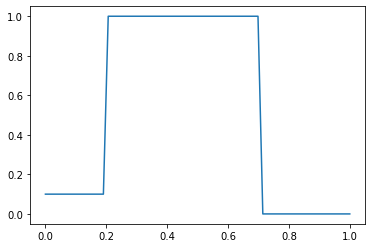

In [146]:
z_perturb = lower+t_rand*(upper-lower)
alpha = [sigma_distr(i) for i in z_perturb]

plt.plot(z, alpha)
plt.show()

下面是论文中对于这条ray对应颜色的计算公式：
$$
C(r)=\int^{t_{f}}_{t_n}T(t)\sigma(r(t))c(r(t),d)\mathrm{d}t\\
\mathrm{where\ }T(t)=e^{-\int^{t}_{t_n}\sigma(r(s))\mathrm{d}s}
$$

上面的$T(t)$表示光沿射线经过介质到$t$点还剩下多少的比例，记作Transmittance

其中$\int^{t}_{t_n}\sigma(r(s))\mathrm{d}s$记作$\tau$，表示optical depth

这里出现的积分就是因为$\sigma$是连续的，就像概率密度函数一样把它积出来才是有意义的值

这样，这个包含$T(t)$的公式$C(r)=\int^{t_f}_{t_n}T(t)\sigma(r(t))c(r(t),d)\mathrm{d}t$就很好理解了，就是每个横截面的微元到达的光强乘以这个图层的透明度作为颜色的权重再乘以对应的颜色，然后积一起就可以了

更多这边部分的内容在

> Real-Time Rendering 4th Chapter 14

里面讨论了更多关于Volumetric Rendering的信息

离散化，就是把Transmittance积分那里改成最简单的黎曼和一条一条加起来，我们有

$$
T_i=e^{-\sum^{i-1}_{j=1}\sigma_j(t_{j+1}-t_j)}
$$

所以下这一步，在我们的`raw2outputs`里，把这个一条ray上的density distribution转化为Transmittance



(63,)


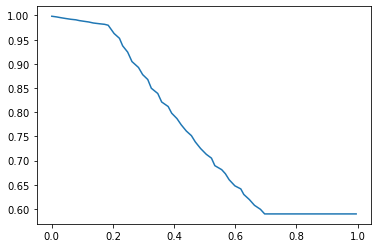

In [147]:
dists = z_perturb[1:]-z_perturb[:-1]
print(dists.shape)
dists = np.concatenate((dists, [1e10]), -1) #最后一段算作无穷远

Transmittance = np.exp(-1 * np.cumsum(np.maximum(0, alpha) * dists))
#Transmittance = np.cumprod(np.exp(-1 * np.maximum(0, alpha) * dists)) #一样的试了，论文里是先计算alpha再用alpha计算Transmittance


plt.plot(z_perturb, Transmittance)
plt.show()

再回到我们的渲染方程上

这样整成$N$个分区后，$C(r)$的积分就可以改写成求和了
$$
C(r)=\sum^{n}C(r)_i=\sum^{n}\int^{t_{i+1}}_{t_i}T(t)\sigma(r(t))c(r(t),d)\mathrm{d}t
$$
由于radience field的连续性，采样点$t_i$对应的$\sigma(r(t))$和$c(r(t),d)$都可以直接给出并近似为这一段的值(直接从积分里提出来)，记为$\sigma_i,c_i$，但$T(t)$是需要我们再手动去求的，即要求两个采样点之间的Transmittance，而不是从near开始的Transmittance

然后论文里通过下面的推导，来简化了整个计算过程

$$
C(r)_i=\sigma_i c_i\int^{t_{i+1}}_{t_i}e^{-\int^{t}_{t_n}\sigma(s)\mathrm{d}s}\mathrm{d}t\\
=\sigma_i c_i\int^{t_{i+1}}_{t_i}
e^{-\int^{t_i}_{t_n}\sigma(s)\mathrm{d}s}
e^{-\int^{t}_{t_i}\sigma(s)\mathrm{d}s}
\mathrm{d}t\\
=\sigma_i c_i T_i\int^{t_{i+1}}_{t_i}
e^{-\int^{t}_{t_i}\sigma(s)\mathrm{d}s}
\mathrm{d}t\\
=\sigma_i c_i T_i\int^{t_{i+1}}_{t_i}
e^{-({t}-{t_i})\sigma_i}
\mathrm{d}t\ 因为是平均分布\\
= c_i T_i
(1-e^{-({t_{i+1}}-{t_i})\sigma_i})\ 直接算积分
$$

这样，我们通过$density\times transmittance$，就得到了ray上每个采样点的权重



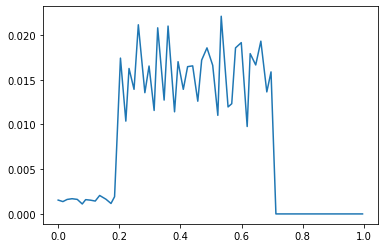

In [148]:
alpha = 1 - np.exp(-1 * np.maximum(0, alpha) * dists)
plt.plot(z_perturb, alpha)
plt.show()

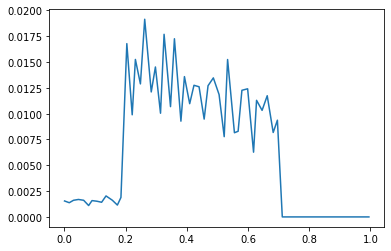

In [149]:
weight = alpha * Transmittance
plt.plot(z_perturb, weight)
plt.show()

这里因为sampling的时候加了preturb所以会抖，调小一些看出来整体上这一段的density相同但是权重是下降的（开始写的第一个分布函数跑出来的weight感觉怎么和density一样属实让鼠鼠困惑了一下，直接改成阶梯函数看上去应该是对的）

有了上面的weights，就爽啦，点乘每个采样点的MLP预测出来的值就是最终的颜色，ray上求个数学期望就是深度图
如上图因为有density的区域集中在0.2-0.7直接，所以其他区域按照之前的（均匀采样+随机）的方法就白采了，所以原始的这篇NeRF根据上面这个corase sampling的结果再做一次fine sampling的采样，再优化这两个，就是图形学里很常见的corase to fine的操作，这里就不展开啦

上面回顾一下基础内容，下面我们来看一下mip NeRF 360对sampling的补充操作

>鼠鼠选了这篇DVGO感觉要补好多论文呀

# Mip-NeRF 360 sampling

Motivation: 因为三维重建本身就是一个很ill的问题，所以在用NeRF做三维重建还是不可避免的出现一些artifacts，就是因为可行解多了——所以我们要加regulation! 把结果变成我们希望的样子！

这篇Mip-NeRF 360主要针对的是NeRF重建带来的“floaters”和“background collapse”

floater指的是重建中前景出现的一些半透明看上去像云一样的漂浮物，background collapse指的是远处的背景被建模成了半透明的情况

之前的NeRF也处理了这个问题，就是之前我们去采样的时候加了噪声，然后Mip-NeRF 360说它去优化上面的这个权重更加有效率，即这个权重应该是单峰的而且峰的宽度应该尽可能小，这样比较符合物理现实

所以就是变成了数学推导，把这个函数分布变成我们期望的样子





In [ ]:

from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# 定义函数
def f(x):
    return np.sin(2 * np.pi * x)

# 生成训练数据
x_train = torch.linspace(0, 1, 256)
y_train = torch.from_numpy(f(x_train.numpy())).float()

# 定义模型
model = torch.nn.Sequential(
    torch.nn.Linear(1, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1),
)

# 定义损失函数和优化器
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 训练模型
for epoch in range(1000):
    y_pred = model(x_train.unsqueeze(1))
    loss = criterion(y_pred.squeeze(), y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))

# 生成测试数据
x_test = torch.linspace(0, 1, 100)
y_test = torch.from_numpy(f(x_test.numpy())).float()

# 在测试数据上评估模型
with torch.no_grad():
    y_pred = model(x_test.unsqueeze(1))
    loss = criterion(y_pred.squeeze(), y_test)
    print('Test Loss: {:.4f}'.format(loss.item()))

# DVGO sampling